In [38]:
#Proyecto: Clasificación de galaxias mediante imágenes (clasificación multietiqueta)
#Objetivo: Desarrollar un modelo de aprendizaje automático capaz de clasificar galaxias en múltiples categorías basándose en imágenes astronómicas.

#Importar paquetes necesarios
import os, glob, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms, models

#Configuraciones generales
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
DATA_DIR = '.\Datasets'

print(f'DEVICE: {DEVICE}')
IMG_TRAIN_DIR = os.path.join(DATA_DIR, 'images_training_rev1')
IMG_TEST_DIR = os.path.join(DATA_DIR, 'images_test_rev1')
LABELS_CSV = os.path.join(DATA_DIR, 'training_solutions_rev1.csv')
SUBMISSION_CSV = os.path.join(DATA_DIR, 'all_zeros_benchmark.csv')

DEVICE: cuda


In [39]:
#Preprocesamientos

labels_df = pd.read_csv(LABELS_CSV) #Lectura del archivo CSV de etiquetas
print(f'Labels DataFrame shape: {labels_df.shape}')
print(f'First 8 columns: {labels_df.columns[:8].to_list()}')

bench = pd.read_csv(SUBMISSION_CSV) #Lectura del archivo CSV de benchmark
#Usar el orden de las filas del benchmark para el conjunto de prueba y estar seguros de que las predicciones se alinean correctamente
target_cols = bench.columns[1:].to_list()
print(f'Benchmark DataFrame shape: {bench.shape}')
print(f'Target columns: {target_cols}')

#Asegurarse de que las columnas de etiquetas coincidan con las del benchmark y estén en el mismo orden
missing_taget_cols = [col for col in target_cols if col not in labels_df.columns]
assert len(missing_taget_cols) == 0, f'Missing target columns in labels_df: {missing_taget_cols}'


Labels DataFrame shape: (61578, 38)
First 8 columns: ['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2']
Benchmark DataFrame shape: (79975, 38)
Target columns: ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']


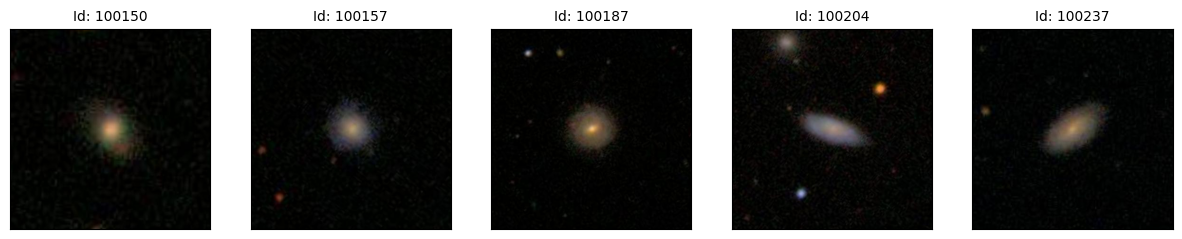

In [40]:
#Visualización de imágenes

def show_image(dir, num_images=5, ids=None):
    fig = plt.figure(figsize=(15, 5))
    for j in range(10, 10 + num_images):
        img_path = os.path.join(dir, str(ids[j]) + '.jpg')
        img = imread(img_path) 
        ax = fig.add_subplot(1, num_images, j - 10 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f'Id: {ids[j]}', fontsize=10)  
    plt.show()

labels_id = labels_df['GalaxyID'].tolist()
show_image(IMG_TRAIN_DIR, num_images=5, ids=labels_id)